14:39:52 - cmdstanpy - INFO - Chain [1] start processing
14:39:52 - cmdstanpy - INFO - Chain [1] done processing


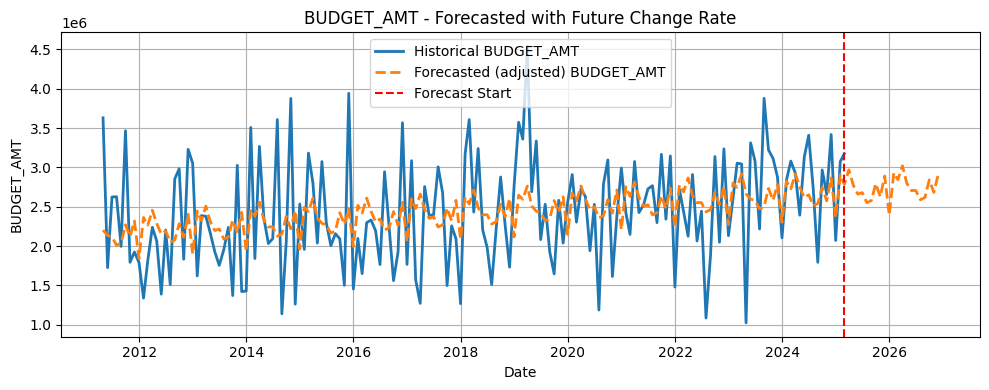

14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] done processing


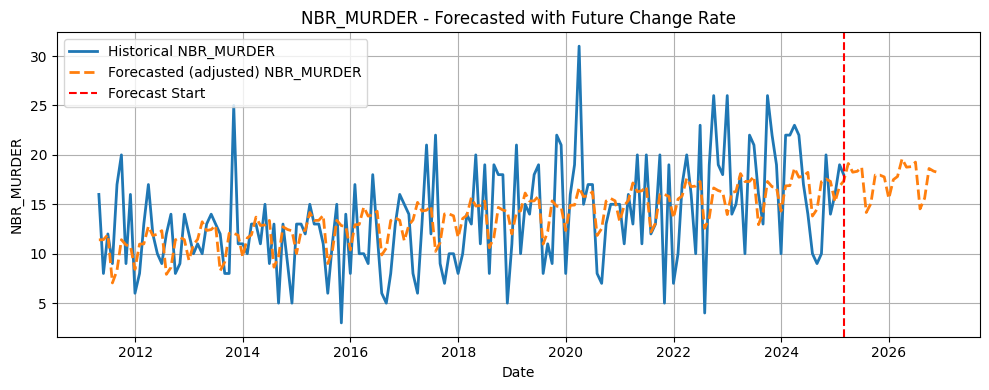

14:39:53 - cmdstanpy - INFO - Chain [1] start processing
14:39:53 - cmdstanpy - INFO - Chain [1] done processing


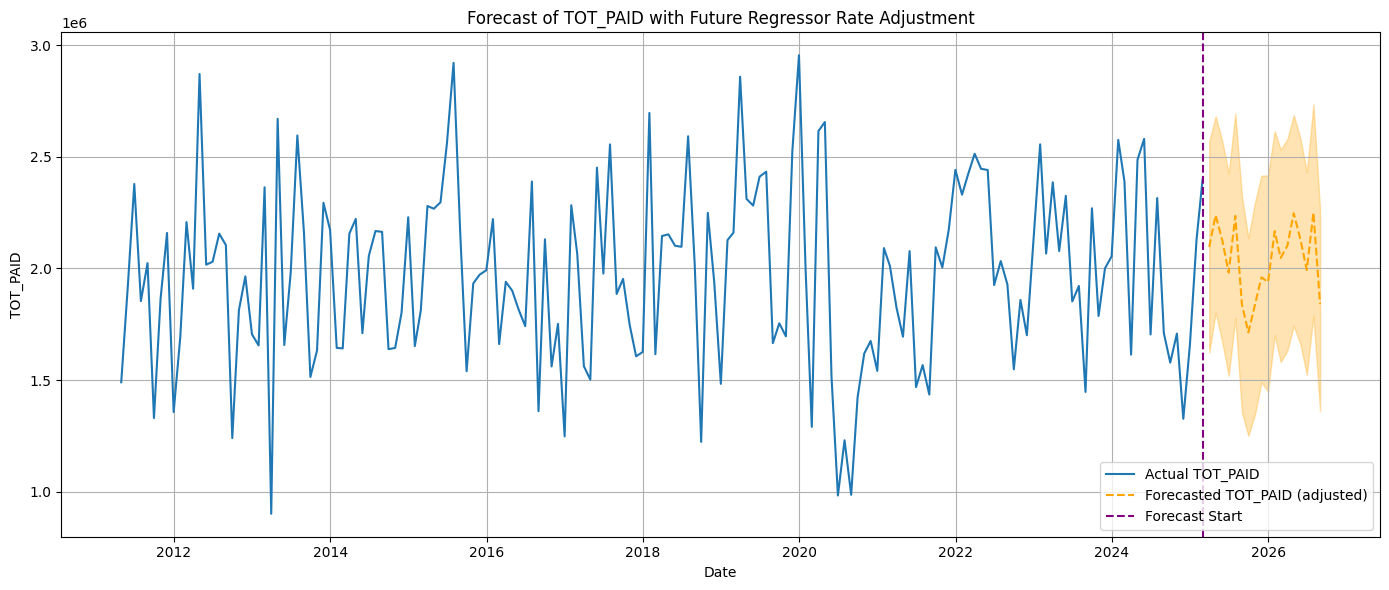


📁 Regressor forecasts saved to 'regressor_forecasts.csv'

🔮 Forecasted TOT_PAID from 2025-03-31:
           ds          yhat    yhat_lower    yhat_upper
0  2025-03-31  2.096276e+06  1.621947e+06  2.569950e+06
1  2025-04-30  2.238561e+06  1.801722e+06  2.682601e+06
2  2025-05-31  2.127128e+06  1.670374e+06  2.571736e+06
3  2025-06-30  1.981839e+06  1.519065e+06  2.426010e+06
4  2025-07-31  2.235879e+06  1.776427e+06  2.694119e+06
5  2025-08-31  1.837607e+06  1.353217e+06  2.324254e+06
6  2025-09-30  1.713506e+06  1.250103e+06  2.136261e+06
7  2025-10-31  1.837874e+06  1.346038e+06  2.296371e+06
8  2025-11-30  1.960126e+06  1.489691e+06  2.415828e+06
9  2025-12-31  1.939300e+06  1.448074e+06  2.417610e+06
10 2026-01-31  2.167236e+06  1.701213e+06  2.615619e+06
11 2026-02-28  2.047271e+06  1.580480e+06  2.533225e+06
12 2026-03-31  2.101621e+06  1.631152e+06  2.579817e+06
13 2026-04-30  2.247586e+06  1.742821e+06  2.687255e+06
14 2026-05-31  2.131469e+06  1.661192e+06  2.583543e+06
15 202

In [44]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# === Step 1: Load data ===
file_path = "C:/GitHub/Machine-Learning/data/BCM_DATA.csv"
df = pd.read_csv(file_path, parse_dates=["ACC_MONTH"])
df = df.sort_values("ACC_MONTH")

# Prepare columns
df['ds'] = df['ACC_MONTH']
df['y'] = df['TOT_PAID']
regressors = ['BUDGET_AMT', 'NBR_MURDER']
forecast_horizon = 18


# === Step 3: Forecast each regressor normally ===
regressor_forecasts = {}

for reg in regressors:
    reg_df = df[['ds', reg]].rename(columns={reg: 'y'}).copy()

    # Fit Prophet on historical data
    reg_model = Prophet(yearly_seasonality=True)
    reg_model.fit(reg_df)

    total_needed = forecast_horizon + 3
    reg_future = reg_model.make_future_dataframe(periods=total_needed, freq='ME')
    reg_forecast = reg_model.predict(reg_future)
    reg_forecast = reg_forecast[['ds', 'yhat']].rename(columns={'yhat': reg})

    # Apply change rate only to future values
    last_date = df['ds'].max()
    forecast_start = last_date + pd.offsets.MonthEnd(1)
    future_mask = reg_forecast['ds'] >= forecast_start

    
    regressor_forecasts[reg] = reg_forecast

    # === Plot regressor trend ===
    plt.figure(figsize=(10, 4))
    plt.plot(reg_df['ds'], reg_df['y'], label=f'Historical {reg}', linewidth=2)
    plt.plot(reg_forecast['ds'], reg_forecast[reg], '--', label=f'Forecasted (adjusted) {reg}', linewidth=2)
    plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
    plt.title(f"{reg} - Forecasted with Future Change Rate")
    plt.xlabel("Date")
    plt.ylabel(reg)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Step 4: Merge full regressor forecasts ===
full_df = df[['ds', 'y']].copy()
for reg in regressors:
    full_df = full_df.merge(regressor_forecasts[reg], on='ds', how='outer')

# Fill missing and sort
full_df = full_df.sort_values('ds')
full_df[regressors] = full_df[regressors].ffill()

# === Step 5: Prepare future forecast dataframe ===
future_dates = pd.date_range(start=forecast_start, periods=forecast_horizon, freq='ME')
future_df = pd.DataFrame({'ds': future_dates})
for reg in regressors:
    future_df = future_df.merge(regressor_forecasts[reg], on='ds', how='left')
future_df = future_df.dropna(subset=regressors)

# === Step 6: Train Prophet on full historical data ===
train_df = full_df[full_df['y'].notnull()].dropna(subset=regressors).copy()
model = Prophet(yearly_seasonality=True)
for reg in regressors:
    model.add_regressor(reg)
model.fit(train_df)

# === Step 7: Forecast TOT_PAID using adjusted regressors ===
forecast = model.predict(future_df)

# === Step 8: Plot final TOT_PAID forecast ===
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['TOT_PAID'], label='Actual TOT_PAID')
plt.plot(forecast['ds'], forecast['yhat'], '--', label='Forecasted TOT_PAID (adjusted)', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)
plt.axvline(x=last_date, color='purple', linestyle='--', label='Forecast Start')
plt.title("Forecast of TOT_PAID with Future Regressor Rate Adjustment")
plt.xlabel("Date")
plt.ylabel("TOT_PAID")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 3.6: Save regressor forecasts to CSV ===
# Merge forecasted future values for each regressor
merged_regressor_df = pd.DataFrame({'ds': future_dates})
for reg in regressors:
    reg_future_forecast = regressor_forecasts[reg][regressor_forecasts[reg]['ds'] >= forecast_start][['ds', reg]]
    merged_regressor_df = merged_regressor_df.merge(reg_future_forecast, on='ds', how='left')

# Save to CSV
merged_regressor_df.to_csv("C:/GitHub\Machine-Learning/data/regressor_forecasts.csv", index=False)
print("\n📁 Regressor forecasts saved to 'regressor_forecasts.csv'")

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("C:/GitHub\Machine-Learning/data/TOT_Paidforecasts.csv", index=False)

# === Step 9: Display forecast ===
print(f"\n🔮 Forecasted TOT_PAID from {forecast_start.date()}:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


